<a href="https://colab.research.google.com/github/carloslme/handson-ml2-book/blob/main/08_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [8]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction
Reducing dimensionality does cause some information loss (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may make your system perform slightly worse. It also makes your pipelines a bit more complex and thus harder to maintain. So, **if training is too slow, you should first try to train your system with the original data before considering using dimensionality reduction**. In some cases, reducing the dimensionality of the training data may filter out some noise and unnecessary details and thus result in higher performance, but in general it won’t; it will just speed up training.

Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters.

# The curse of dimensionality

High-dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, **the more dimensions the training set has, the greater the risk of overfitting it**.


# Projection methods

In most real-world problems, training instances are not spread out uniformly across all dimensions.

Reducing the dimensionality of your training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

In [ ]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA using SVD decomposition

First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

The projection onto the solid line preserves the maximum variance, while the projection onto the dotted line preserves very little variance and the projection onto the dashed line preserves an intermediate amount of variance.

In short, PCA identifies the axis that accounts for the largest amount of variance in the training set.

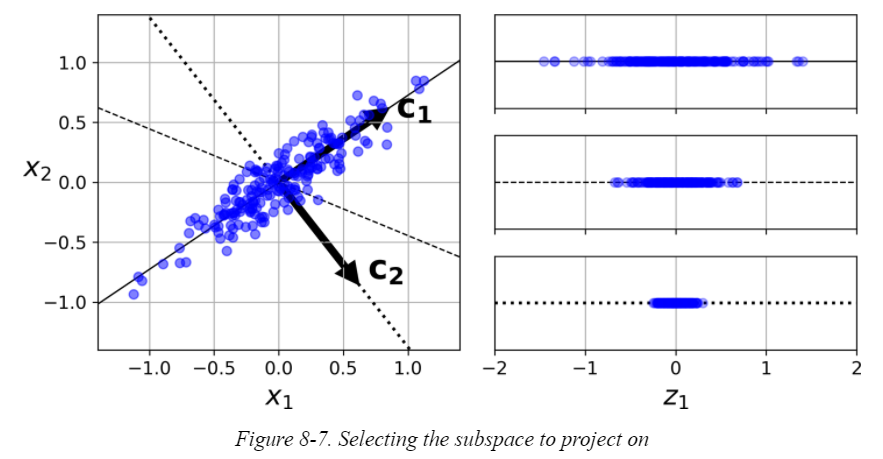

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

**NOTE**

For each principal component, PCA finds a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. However, they will generally still lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are close), but the plane they define will generally remain the same.


To find the principal components of a training set there is a standard matriz factorization technique called Singular Value Decomposition (SVD) that can decompose the training set matrix $X$ into a matrix multiplication of three matrices $U Σ V^{⊺}$ , where $V$ contains the unit vectors that define all the principal components that we are looking for.

**WARNING**

PCA assumes that the dataset is centered around the origin. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

In [ ]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [ ]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [ ]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to d dimensions by projecting it onto the hyperplane defined by the first d principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.



In [ ]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [ ]:
X2D_using_svd = X2D

# PCA using Scikit-Learn
Scikit-Learn automatically takes care of centering the data.


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [ ]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

The PCA object gives access to the principal components that it computed:

In [ ]:
pca.components_


array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [ ]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [ ]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

This output tell us that the 84.2% of the dataset's variance lies along the first PC, and 14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

#Choosing the right number of dimensions
It is simple just to choose the number of dimensions that add up to a sufficiently large portion of the variance, like 95%. Unless, of course, you are reducing dimensionality for data visualization—in that case you will want to reduce the dimensionality down to 2 or 3.

Next code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(np.uint8)

ValueError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
d

Elbow plot of the explained variance as a function of the number of dimensions. In this case, reducing the dimensionality down to about 100 dimensions wouldn't lose too much explained variance. 

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

Explained variance as a function of the number of dimensions.

# PCA for compression
For this example, after applying PCA to the MNIST dataset while preserving 95% of its variance, the dataset is now less than 20% of its original size. The reduction was from 784 features to 150. 

This reduction size can speed up a classification algorithm (SVM) tremendously.

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [ ]:
pca.n_components_

In [ ]:
np.sum(pca.explained_variance_ratio_)

It is possible to decompress the reduced dataset back to the 784 original dimensions by applying the inverse transformation of the PCA projection. Although it will not give you back the original data, since the projection lost within 5% variance, it will likely be close to the original data. 

The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the *reconstruction error*.

In [ ]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [ ]:
X_reduced_pca = X_reduced

In [ ]:
X_reduced_pca

# Randomized PCA
Using the `svd_solver` hyperparameter to "`randomized`", Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first $d$ principal components.

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Incremental PCA
Incremental PCA (IPCA) allows you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

#### Using memmap()

In [ ]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [ ]:
del X_mm

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# PCA Kernel
In Chapter 5 we discussed the kernel trick, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space. 


It turns out that **the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction**. This is called Kernel PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

In [ ]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


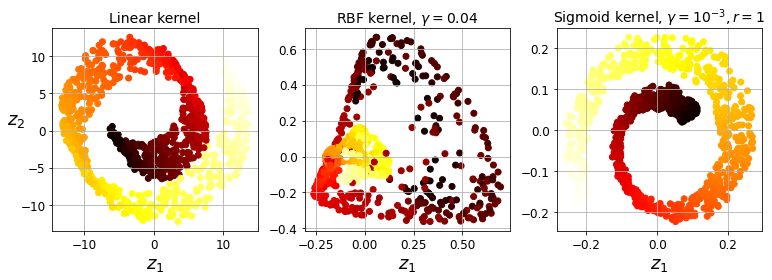

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

# Selecting a Kernel and Tuning Hyperparameters
There is no obvious performance measure to help you select the best kernel and hyperparameter values. Dimensionality reduction is often a preparation step for supervised learning task (e.g. classification), so you can use grid search to select the kernel and hyperparameters that lead to the best performance on that task.

Next code creates a two-step pipeline, fir reducing dimensionality to two dimendiones using kPCA, then applying Logistic Regression dor classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

In [ ]:
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

In [ ]:
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [ ]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [ ]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.786308795766125

# Locally Linear Embedding (LLE)
Is another powerful *nonlinear dimensionality reduction* (NLDR) technique. It is a technique that does not rely on projections, like the previuos algorithms do. 

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

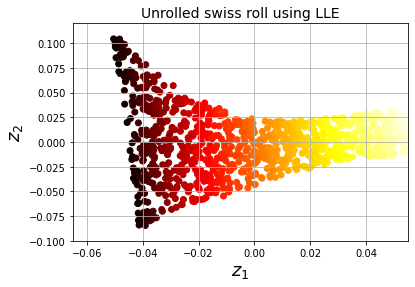

In [ ]:
import matplotlib.pyplot as plt

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

# save_fig("lle_unrolling_plot")
plt.show()

Now, the Swiss roll is completely unrolled, and the distances between instances are locally well preserved. However, distances are not preserved on a larger scale: the left part of the unrolled Swiss is stretched, while the roght part is squeezed. 

# Other Dimensionality Reduction Techniques
* **Random projections**: projects the data to a lower-dimensional space using a random linear projection.
* **Multidimensional Scaling (MDS)**: Reduces dimensionality while trying to preserve the distances between the instances.
* **Isomap**: Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.
* **t-Distributed Stochastic Neighbor Embedding (t-SNE)**: Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).
* **Linear Discriminant Analysis (LDA)**:  Is a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as an SVM classifier.

# Exercises

## Exercise 1
**What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?**

The main motivations for dimensionality reduction are: 
* To speed up a subsequent training algorithm (in some cases it may even remove noise and redundant features, making the training algorithm perform better) 
* To visualize the data and gain insights on the most important features 
* To save space (compression)

The main drawbacks are: 
* Some information is lost, possibly degrading the performance of subsequent training algorithms. 
* It can be computationally intensive. 
* It adds some complexity to your Machine Learning pipelines.



## Exercise 2

**What is the curse of dimensionality?**


The curse of dimensionality refers to the fact that many problems that do not exist in low-dimensional space arise in high-dimensional space. In Machine Learning, one common manifestation is the fact that randomly sampled high-dimensional vectors are generally very sparse, increasing the risk of overfitting and making it very difficult to identify patterns in the data without having plenty of training data.


## Exercise 3
**Once a dataset’s dimensionality has been reduced, is it possible to reverse the operation? If so, how? If not, why?**

Once a dataset’s dimensionality has been reduced using one of the algorithms we discussed, it is almost always impossible to perfectly reverse the operation, because some information gets lost during dimensionality reduction. Moreover, while some algorithms (such as PCA) have a simple reverse transformation procedure that can reconstruct a dataset relatively similar to the original, other algorithms (such as T-SNE) do not.


## Exercise 4
**Can PCA be used to reduce the dimensionality of a highly nonlinear dataset?**

PCA can be used to significantly reduce the dimensionality of most datasets, even if they are highly nonlinear, because it can at least ride of useless dimensions. Howerver, if there are no useless dimensions - as in Swiss roll dataset- then reducing dimensionality with PCA will lose too much information. You want to unroll the Swiss roll, not to squash it.



## Exercise 5
**Suppose you perform PCA on a 1,000-dimensional dataset, setting the explained variance ratio to 95%. How many dimensions will the resulting dataset have?**

It depends on tha dataset. It could be a any number between 1 and 950. Plotting the explained variance as a function of the number of dimensions is one way to get a rough idea of the dataset's intrinsic dimensionality.


## Exercise 6
**In what cases would you use vanilla PCA, Incremental PCA, Randomized PCA, or Kernel PCA?**

* Regular PCA is the default, but it works only if the dataset fits in memory.
* Incremental PCA is useful for large datasets that don't fit in memory, but is slower that regular PCA, so if the dataset fits in memory you should prefer regular PCA. Incremental PCA is also useful for online tasks, when you need to apply PCA on the fly, every time a new instance arrives.
* Randomized PCA is useful when you want to considerably reduce dimensionality and the dataset fits in memory; in this case, it is much faster than regular PCA.
* Kernel PCA is useful for nonlinear datasets.



## Exercise 7
**How can you evaluate the performance of a dimensionality reduction algorithm on your dataset?**

A dimensionality reductions algorithm performs well if it eliminates a lot of dimensions from the dataset without losing too much information. 

One way to measure this is to apply a reverse transformation and measure the reconstruction error. However, not all dimensionality reduction algorithms provide a reverse transformation. 

Alternatively, if you are using dimensionality reduction as a preprocessing step before another ML algorithm, then you can simply measure the performance of that second algorithm; if dimensionality reduction did not lose too much information, then the algorithm should perform just as well as when using the original dataset.



## Exercise 8
**Does it make any sense to chain two different dimensionality reduction algorithms?**

It does. A common example is using PCA to quickly get rid of a large number of useless dimensiones, then applying another much slower dimensionality reduction algorithm, such as LLE. This two-step approach will likely yield the same performance as using LLE onyl, but in a fraction of the time.


## Exercise 9
Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
import time 

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 46.14s


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

Use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

Train a new Random Forest classifier on the reduced dataset and see how long it takes.

In [ ]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [ ]:
print("Training on reduced dataset took {:.2f}s".format(t1 - t0))

Training on reduced dataset took 112.68s


Dimensionality reduction does not always lead to faster training time: it dependes on the dataset, the model and the training algorithm.


Evaluate the classifier on the test set.

In [ ]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality we do lose some useful signal in the process. However, the performance drop is rather sever in this case. So PCA really did not help: it slowed down training and reduced performance.

Using Softmax Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 43.66s


In [ ]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In this case, softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set.

Let's train the softmax regression model using the reduced dataset:

In [ ]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print("Training took {:.2f}s".format(t1 - t0))


Training took 12.73s


Reducing dimensionality led to over 2x speedup. 

In [ ]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

There is a slight drop in performance, which might be reasonable price to pay for a 2x speedup, depending on the application.

## Exercise 10
Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(np.uint8)

np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Use TSNE to reduce dimensionality down to 2D so we can plot the dataset

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

Using Matplotlib's scatter() function to plot a scatterplot.

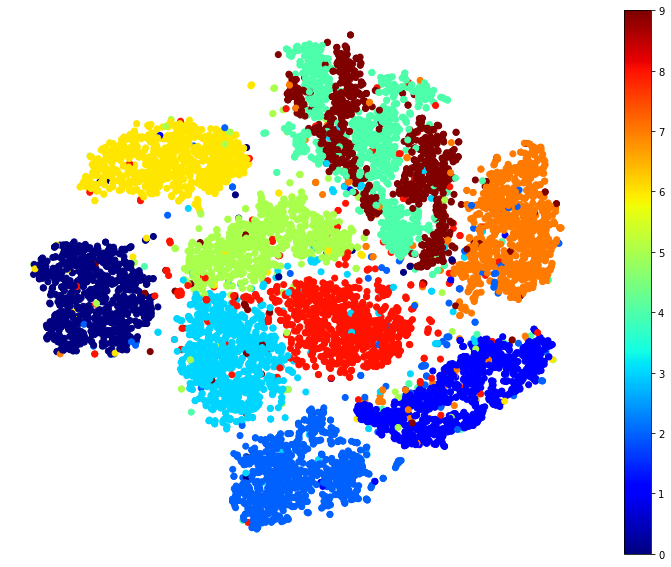

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

This plot tells us which numbers are easily distinguishable from the others: 0s, 6s and most 8s are rather well separated clusters, and also tell us which numbers are often hard to distinguish as 4s, 5s and 3s.

Fot this, let's focus on digits 2, 3 and 5, which seem to overlap a lot.

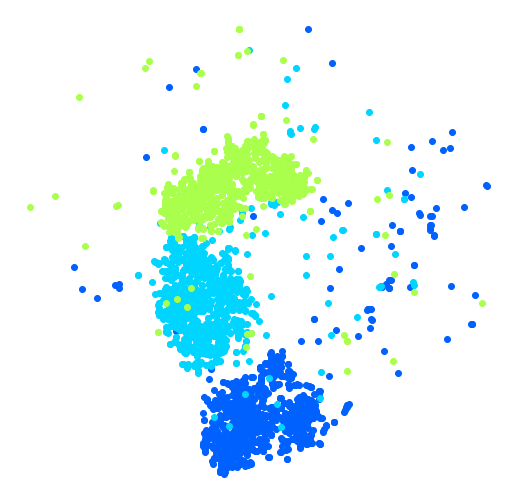

In [9]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Running t-SNE on these 3 digits:

In [12]:
idx = (y == 2) | (y == 3) | (y == 5) # Getting just 2, 3 and 5
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

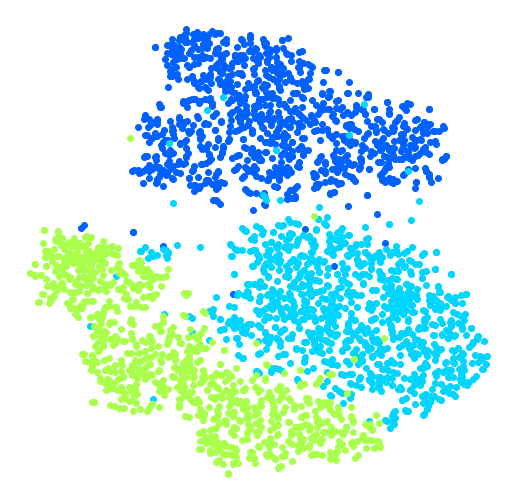

In [13]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Right now, the clusters have far less overlap. To distinguish the numbers corresponfing to each digits, lets create a `plot_digits()` function that draw a scatterplot plus write colored digits, with a minimum distance guaranteed between these digits. If the digit image are provided, they are plotted instead.

In [14]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [18]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
  # Scale the input features so that they range from 0 to 1
  X_normalized = MinMaxScaler().fit_transform(X)
  # Create the list of coordinates of the digits plotted so far.
  # We pretend that one is already plotted far away at the start, to 
  # avoid 'if' statements in the loop below
  neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
  plt.figure(figsize=figsize)
  cmap = mpl.cm.get_cmap("jet")
  digits = np.unique(y)
  for digit in digits:
      plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
  plt.axis("off")
  ax = plt.gcf().gca()  # get current axes in current figure
  for index, image_coord in enumerate(X_normalized):
      closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
      if closest_distance > min_distance:
          neighbors = np.r_[neighbors, [image_coord]]
          if images is None:
              plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                        color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
          else:
              image = images[index].reshape(28, 28)
              imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
              ax.add_artist(imagebox)

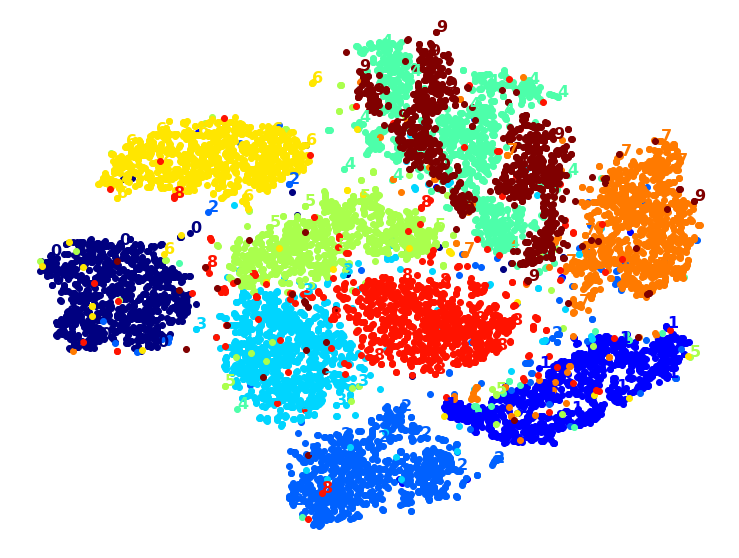

In [19]:
plot_digits(X_reduced, y)

 Let's try with the digit images:

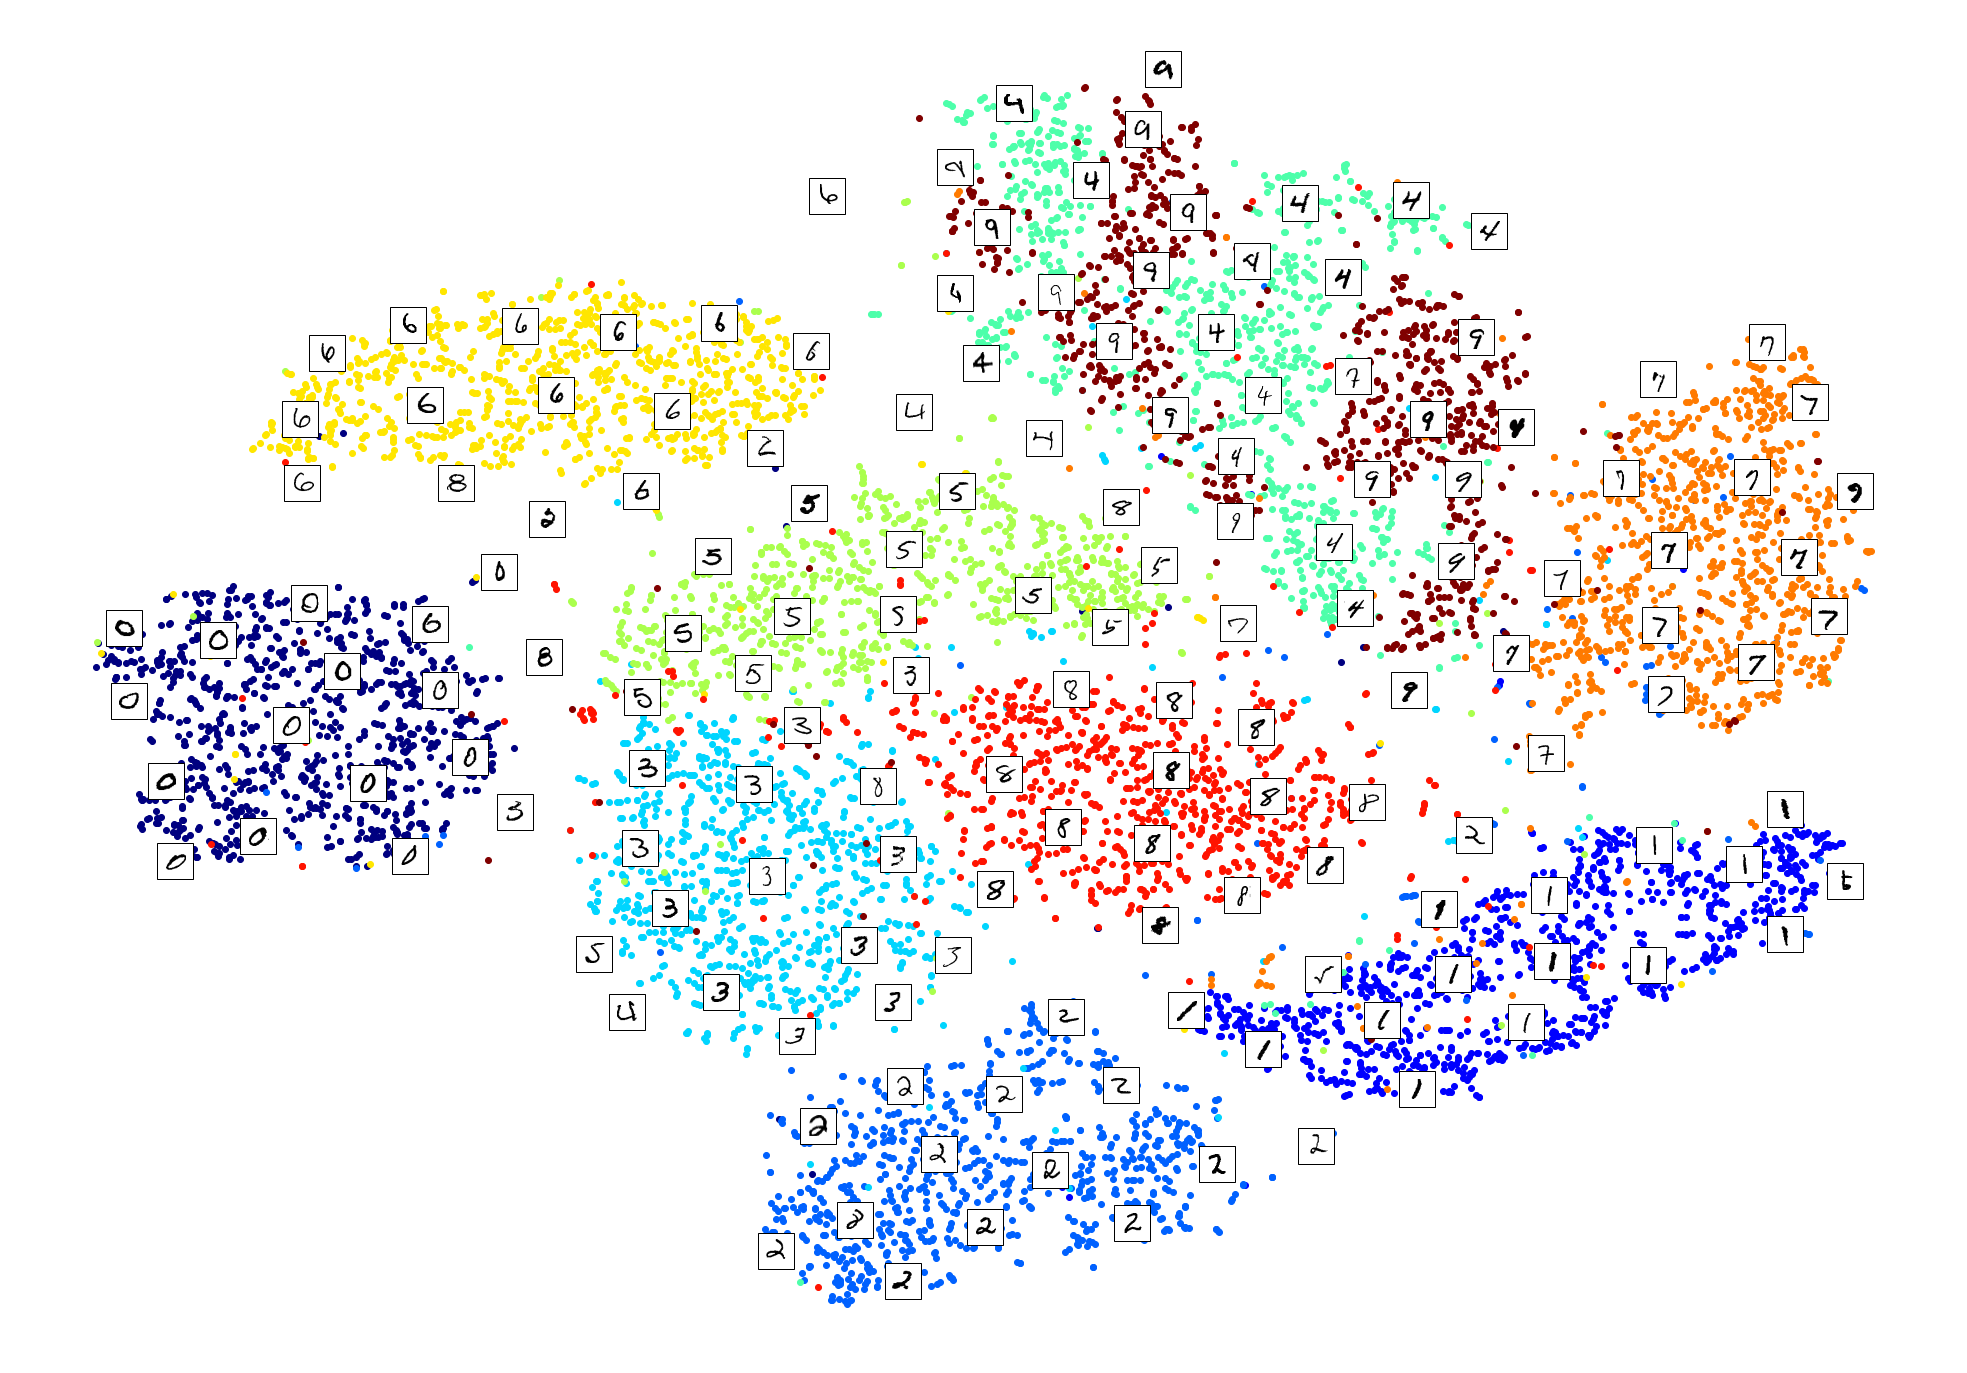

In [20]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))


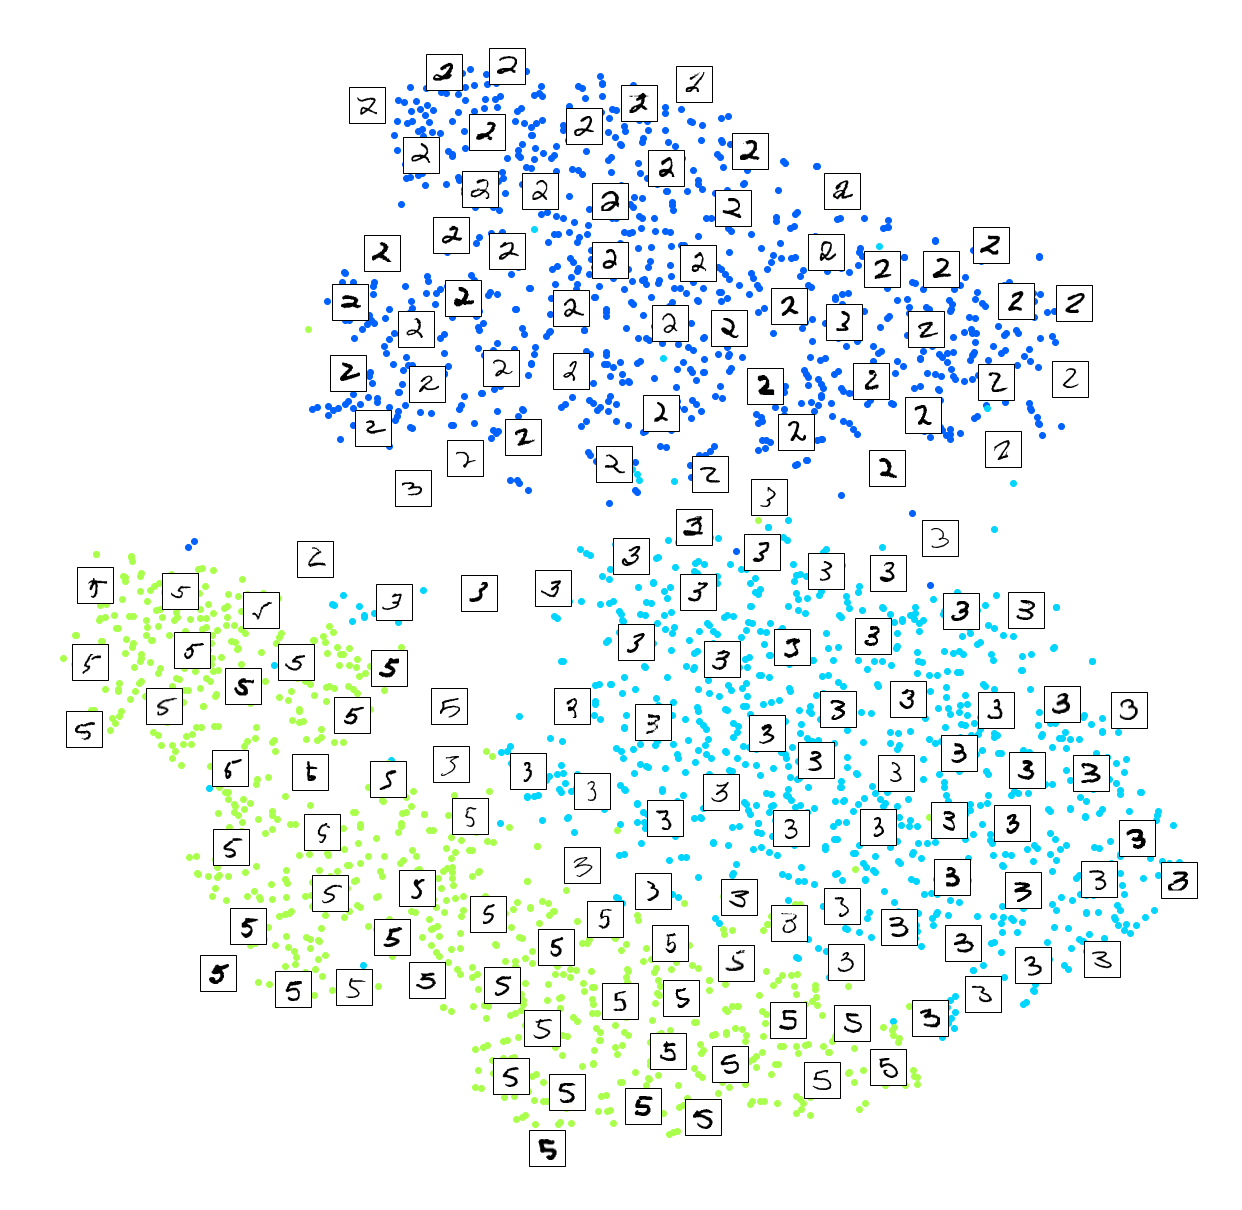

In [21]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))